# MTCNN with landmark (should be used folloed MTCNN)

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Assemble O-net data

In [ ]:
import os
import sys
sys.path.append(os.getcwd())


onet_postive_file = './anno_store/pos_48.txt'
onet_part_file = './anno_store/part_48.txt'
onet_neg_file = './anno_store/neg_48.txt'
onet_landmark_file = './anno_store/landmark_48.txt'
imglist_filename = './anno_store/landmark/imglist_anno_48.txt'

if __name__ == '__main__':

    anno_list = []

    anno_list.append(onet_postive_file)
    anno_list.append(onet_part_file)
    anno_list.append(onet_neg_file)
    anno_list.append(onet_landmark_file)
    chose_count = assemble_data(imglist_filename ,anno_list)
    print("ONet train annotation result file path:%s" % imglist_filename)
    

## Train O-net

In [ ]:
import os
import sys
sys.path.append(os.getcwd())



def train_net(annotation_file, model_store_path,
                end_epoch=16, frequent=200, lr=0.01,lr_epoch_decay=[], batch_size=128, use_cuda=True,load=''):

    imagedb = ImageDB(annotation_file)
    gt_imdb = imagedb.load_imdb()
    #gt_imdb = imagedb.append_flipped_images(gt_imdb)
    print('load done')

    train_onet(model_store_path=model_store_path, end_epoch=end_epoch, 
        imdb=gt_imdb, batch_size=batch_size, frequent=frequent, lr_epoch_decay=lr_epoch_decay,
        base_lr=lr, use_cuda=use_cuda)

if __name__ == '__main__':

    print('train ONet argument:')

    annotation_file = "./anno_store/landmark/imglist_anno_48.txt"
    model_store_path = "./model_store/landmark"
    end_epoch = 10
    lr = 0.0001
    batch_size = 320

    use_cuda = False
    frequent = 500
    lr_epoch_decay = [8]
    load=''

    train_net(annotation_file, model_store_path,
                end_epoch, frequent, lr,lr_epoch_decay, batch_size, use_cuda,load)

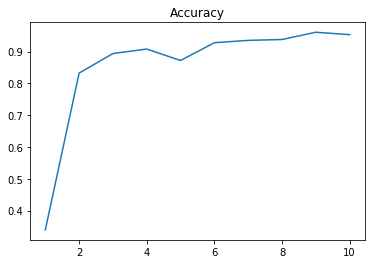

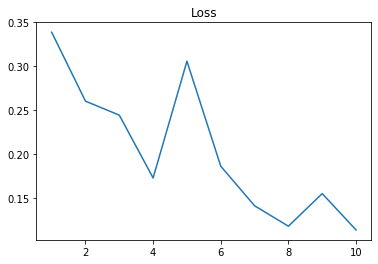

## Demo

In [ ]:
import cv2
if __name__ == '__main__':

    #trained model
    p_model_path = "./model_store/pnet_epoch_10.pt"
    r_model_path = "./model_store/rnet_epoch_10.pt"
    o_model_path = "./model_store/onet_model_final.pt"#"./model_store/landmark/onet_epoch_10.pt"
    pnet, rnet, onet = create_mtcnn_net(p_model_path=p_model_path, r_model_path=r_model_path, o_model_path=o_model_path, use_cuda=False)
    mtcnn_detector = MtcnnDetector(pnet=pnet, rnet=rnet, onet=onet, min_face_size=24,threshold=[0.6, 0.7, 0.7])

    img = cv2.imread("./6.jpg")
    img_bg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    bboxs, landmarks = mtcnn_detector.detect_face(img)
    print(bboxs.shape)
    
    # print box_align
    save_name = './r_6.jpg'
    vis_face(img_bg,bboxs,landmarks, save_name)


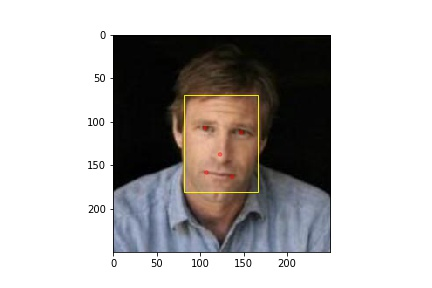

## Face alignent according to the five landmarks

In [ ]:
import os
import cv2
import numpy
import logging
import tensorflow as tf
 
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)
 
# different size of the final images and their target coordinates
imgSize1 = [112,96]
imgSize2 = [112,112]
coord5point1 = [[30.2946, 51.6963],  # 112x96
               [65.5318, 51.6963],
               [48.0252, 71.7366],
               [33.5493, 92.3655],
               [62.7299, 92.3655]]
coord5point2 = [[30.2946+8.0000, 51.6963], # 112x112
               [65.5318+8.0000, 51.6963],
               [48.0252+8.0000, 71.7366],
               [33.5493+8.0000, 92.3655],
               [62.7299+8.0000, 92.3655]]
 
def transformation_from_points(points1, points2):
    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)
    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2
    U, S, Vt = numpy.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    return numpy.vstack([numpy.hstack(((s2 / s1) * R,c2.T - (s2 / s1) * R * c1.T)),numpy.matrix([0., 0., 1.])])
 
def warp_im(img_im, orgi_landmarks,tar_landmarks):
    pts1 = numpy.float64(numpy.matrix([[point[0], point[1]] for point in orgi_landmarks]))
    pts2 = numpy.float64(numpy.matrix([[point[0], point[1]] for point in tar_landmarks]))
    M = transformation_from_points(pts1, pts2)
    dst = cv2.warpAffine(img_im, M[:2], (img_im.shape[1], img_im.shape[0]))
    return dst
 
def main():   
    pic_path = './testalign'
    p_model_path = "./model_store/pnet_epoch_10.pt"
    r_model_path = "./model_store/rnet_epoch_10.pt"
    o_model_path = "./model_store/onet_model_final.pt"
    pnet, rnet, onet = create_mtcnn_net(p_model_path=p_model_path, r_model_path=r_model_path, o_model_path=o_model_path, use_cuda=False)
    mtcnn_detector = MtcnnDetector(pnet=pnet, rnet=rnet, onet=onet, min_face_size=24,threshold=[0.6, 0.7, 0.7])
    
    lower_threshold = 100
    upper_threshold = 200
    num = 0
 
    pic_name_list = os.listdir(pic_path)
    for every_pic_name in pic_name_list:
        #print(every_pic_name)
        img_im = cv2.imread(os.path.join(pic_path , every_pic_name))
        #print(pic_path + every_pic_name)
        if img_im is None:
            continue
        else:
            shape = img_im.shape
            height = shape[0]
            width = shape[1]
            bounding_boxes, points = mtcnn_detector.detect_face(img_im)
            
            if bounding_boxes.shape[0] > 0:
                for i in range(bounding_boxes.shape[0]):  # how many bounding boxes
                    print(i)
                    x1, y1, x2, y2 = int(min(bounding_boxes[i][0], min(points[i][:5]))), \
                                     int(min(bounding_boxes[i][1], min(points[i][5:]))), \
                                     int(max(bounding_boxes[i][2], max(points[i][:5]))), \
                                     int(max(bounding_boxes[i][3], max(points[i][5:])))
                    new_x1 = max(int(1.50 * x1 - 0.50 * x2),0)
                    new_x2 = min(int(1.50 * x2 - 0.50 * x1),width-1)
                    new_y1 = max(int(1.50 * y1 - 0.50 * y2),0)
                    new_y2 = min(int(1.50 * y2 - 0.50 * y1),height-1)
                    
 
                    # original landmarks
                    left_eye_x = points[i][:5][0]
                    right_eye_x = points[i][:5][1]
                    nose_x = points[i][:5][2]
                    left_mouth_x = points[i][:5][3]
                    right_mouth_x = points[i][:5][4]
                    left_eye_y = points[i][5:][0]
                    right_eye_y = points[i][5:][1]
                    nose_y = points[i][5:][2]
                    left_mouth_y = points[i][5:][3]
                    right_mouth_y = points[i][5:][4]
 
                    # updated landmarks
                    new_left_eye_x = left_eye_x - new_x1
                    new_right_eye_x = right_eye_x - new_x1
                    new_nose_x = nose_x - new_x1
                    new_left_mouth_x = left_mouth_x - new_x1
                    new_right_mouth_x = right_mouth_x - new_x1
                    new_left_eye_y = left_eye_y - new_y1
                    new_right_eye_y = right_eye_y - new_y1
                    new_nose_y = nose_y - new_y1
                    new_left_mouth_y = left_mouth_y - new_y1
                    new_right_mouth_y = right_mouth_y - new_y1
 
                    face_landmarks = [[new_left_eye_x,new_left_eye_y], 
                                      [new_right_eye_x,new_right_eye_y],
                                      [new_nose_x,new_nose_y],
                                      [new_left_mouth_x,new_left_mouth_y],
                                      [new_right_mouth_x,new_right_mouth_y]]
                    face = img_im[new_y1: new_y2, new_x1: new_x2] 
                    dst1 = warp_im(face,face_landmarks,coord5point1) # 112x96
                    dst2 = warp_im(face,face_landmarks,coord5point2) # 112x112
                    crop_im1 = dst1[0:imgSize1[0],0:imgSize1[1]]
                    crop_im2 = dst2[0:imgSize2[0],0:imgSize2[1]]
                    cv2.imwrite(os.path.join(pic_path , every_pic_name[:-4] + '_' + str(num) + '_align_112x96.jpg'),crop_im1)
                    cv2.imwrite(os.path.join(pic_path , every_pic_name[:-4] + '_' + str(num) + '_align_112x112.jpg'),crop_im2)
                    num = num + 1

In [ ]:
if __name__ == '__main__':
    main()
    cv2.waitKey()
    pass

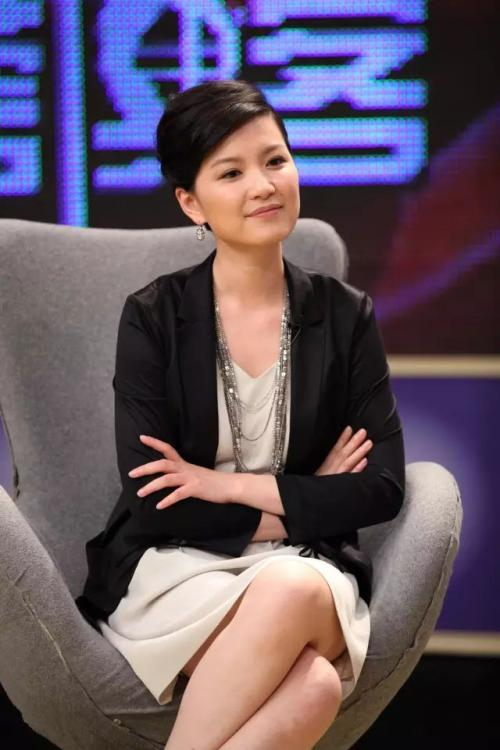


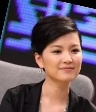